In [122]:
#import packages 
import networkx as nx
import json
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
from collections import deque

In [123]:
#load cnty data 
file_path = '/Users/brookefeinberg/SamplingBalancedForests/t_wa.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    t = json_graph.adjacency_graph(data)

In [124]:
print(len(t))

1784


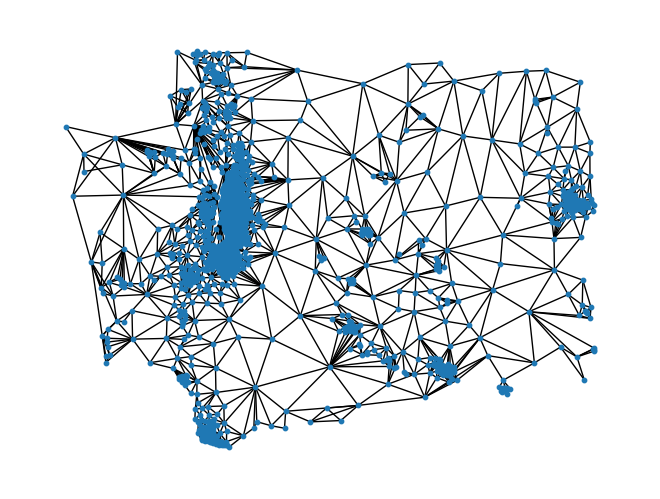

In [125]:
#plot 
import matplotlib.pyplot as plt
node_locations = { v : ( float(t.nodes()[v]["INTPTLON20"]), float(t.nodes()[v]["INTPTLAT20"])) for v in t.nodes() }
plt.figure()
nx.draw(t, node_size = 10, pos = node_locations)
plt.show()

In [127]:
#Wilson's Algorithm

class WilsonsAlgorithm:
    def __init__(self, graph):
        self.graph = graph  #store networkX graph 
        self.adj_list = {v: list(graph.neighbors(v)) for v in graph.nodes() if list(graph.neighbors(v))}  #for each graph node return the neighbors and store it as a dictionary where node is the key and each value corresponds to a list of its neighbors 
        self.InTree = {node: False for node in self.adj_list}  #initalizes dictionary to keep track of whether nodes have been included in the spanning tree -- FALSE as initial value menaing node has yet to be included in the tree 
        self.Next = {node: None for node in self.adj_list}  #initalizes dictionary to track path each node takes in a random walk 
    
    def random_edge(self, v): #randomly selects an edge for a given node v 
        return random.choice(self.adj_list[v]) #retrieves the list of neighbors for node v in the adjacency list and randomly picks one -- simulating step ina  random walk 

    def RandomTreeWithRoot(self, r): #generate random spanning tree with r as the root node 
        self.InTree = {node: False for node in self.adj_list} #initalize all nodes as not in the spanning tree 
        self.InTree[r] = True  #mark root node as in the tree 
        self.Next[r] = -1  #root node has no parent aka no incoming edges 

        for node in self.adj_list: #loops through each nodein the graph, attempting to find a path to the root using a random walk 
            path = []  
            while not self.InTree[node]: #loop continues as long as node is not already in the spanning tree 
                path.append(node)  #record each step of the random walk 
                self.Next[node] = self.random_edge(node) #choose a random neighbor & record it as the next step in the walk (connects node to its next random neighbor in the path)
                node = self.Next[node]  #update next node and the new node so the loop continues till we reach a node already in the spanning tree 
            for vertex in path:  #loop has broken bc we've reached a node already part of the spanning tree 
                self.InTree[vertex] = True  #adds each vertex to the spanning tree from the root outward 

    def sample(self, seed=None):
        if seed is not None: #can include seed later on for reproducible results 
            random.seed(seed)
        root = random.choice(list(self.adj_list.keys()))  #picks a random node to be a root 
        self.RandomTreeWithRoot(root) #builds ranodm spannign tree with the ranodm root chosen 

        spanning_tree = []  #extract edges of spannign tree for plotting 
        for node in self.adj_list: 
            if self.Next[node] != -1 and self.Next[node] is not None: #find nodes connected to another node in the tree 
                spanning_tree.append((node, self.Next[node])) #addes connection or edge as a tuple of two nodes to the spanning tree list 
        return spanning_tree, root #returns all the edges in the form of (node1, node2) and the root node 

    def draw_tree(self, spanning_tree, root, node_locations): #plot the spanning tree on the graph
        plt.figure(figsize=(8, 8))
        nx.draw(self.graph, pos=node_locations, node_size=10, edge_color='lightgray') #draw original graph 
        nx.draw_networkx_edges(self.graph, pos=node_locations, edgelist=spanning_tree, edge_color='red', width=2) #draw spanning tree 
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=[root], node_color='yellow', node_size=50)  #draw root node 
        plt.show()

In [128]:
#Graph Partitioner 
class GraphPartitioner:
    def __init__(self, graph, k):
        self.graph = graph
        self.k = k

    def create_weighted_partitions_and_draw_spanning_tree(self):
        while True:
            wilson = WilsonsAlgorithm(self.graph) #generate random spannign tree using wilson's algorithm 
            spanning_tree, root = wilson.sample() 

            tree_graph = nx.Graph() 
            tree_graph.add_edges_from(spanning_tree)  #take edges form spannign tree and add them to the new graph

            total_nodes = len(tree_graph) 
            ideal_size = total_nodes // self.k
            extra_nodes = total_nodes % self.k
            target_sizes = [ideal_size + 1 if i < extra_nodes else ideal_size for i in range(self.k)] #accomedate odd nodes 

            # step 1: initalize BFS queues 
            partitions = [[] for _ in range(self.k)]
            partition_sizes = [0] * self.k
            bfs_queues = [deque([root])] + [deque() for _ in range(self.k - 1)] 

            visited = set([root])
            partitions[0].append(root)
            partition_sizes[0] += 1

            # step 2: grow partitions with BFS
            for current_partition in range(self.k):
                while partition_sizes[current_partition] < target_sizes[current_partition] and bfs_queues[current_partition]:
                    node = bfs_queues[current_partition].popleft()
                    for neighbor in tree_graph.neighbors(node):
                        if neighbor not in visited:
                            partitions[current_partition].append(neighbor)
                            partition_sizes[current_partition] += 1
                            visited.add(neighbor)
                            bfs_queues[current_partition].append(neighbor)
                            if partition_sizes[current_partition] >= target_sizes[current_partition]:
                                break
                            
                # check if partition has reached the right size--else continue the loop for a new tree
                if partition_sizes[current_partition] < target_sizes[current_partition]:
                    #print("Attempt failed, generating a new spanning tree.")
                    return False          #initalizae for statistical inference 
                    #break  

                # initalize next partition with an unvisited node 
                unvisited_nodes = [n for n in tree_graph.nodes if n not in visited]
                if unvisited_nodes and current_partition + 1 < self.k:
                    seed_node = unvisited_nodes[0]
                    partitions[current_partition + 1].append(seed_node)
                    partition_sizes[current_partition + 1] += 1
                    visited.add(seed_node)
                    bfs_queues[current_partition + 1].append(seed_node)

            # check if all partitions are the right size
            if all(partition_sizes[i] == target_sizes[i] for i in range(self.k)):
                #print("Balanced partitions found.")
                return True
                #break
                
'''
        # Step 3: Plotting 
        node_locations = {v: (float(cnty.nodes()[v]["INTPTLON20"]) - 360 if float(cnty.nodes()[v]["INTPTLON20"]) > 0 else float(cnty.nodes()[v]["INTPTLON20"]),
        float(cnty.nodes()[v]["INTPTLAT20"]))for v in cnty.nodes()}
        pos = node_locations
        plt.figure(figsize=(10, 10))
        base_colors = ['blue', 'green']
        spanning_tree_pos = {node: pos[node] for node in tree_graph.nodes}
        for i, partition in enumerate(partitions):
            nx.draw_networkx_nodes(tree_graph, spanning_tree_pos, nodelist=partition, node_size=50,
                                   node_color=base_colors[i % len(base_colors)], label=f'Partition {i+1}')
        nx.draw_networkx_edges(tree_graph, spanning_tree_pos, edge_color='gray', width=2)
        plt.legend()
        plt.title("Spanning Tree with Weighted, Connected, Balanced Partitions")
        plt.show()
        return True
'''

G = t  
k = 2 
partitioner = GraphPartitioner(G, k)
partitioner.create_weighted_partitions_and_draw_spanning_tree()

False

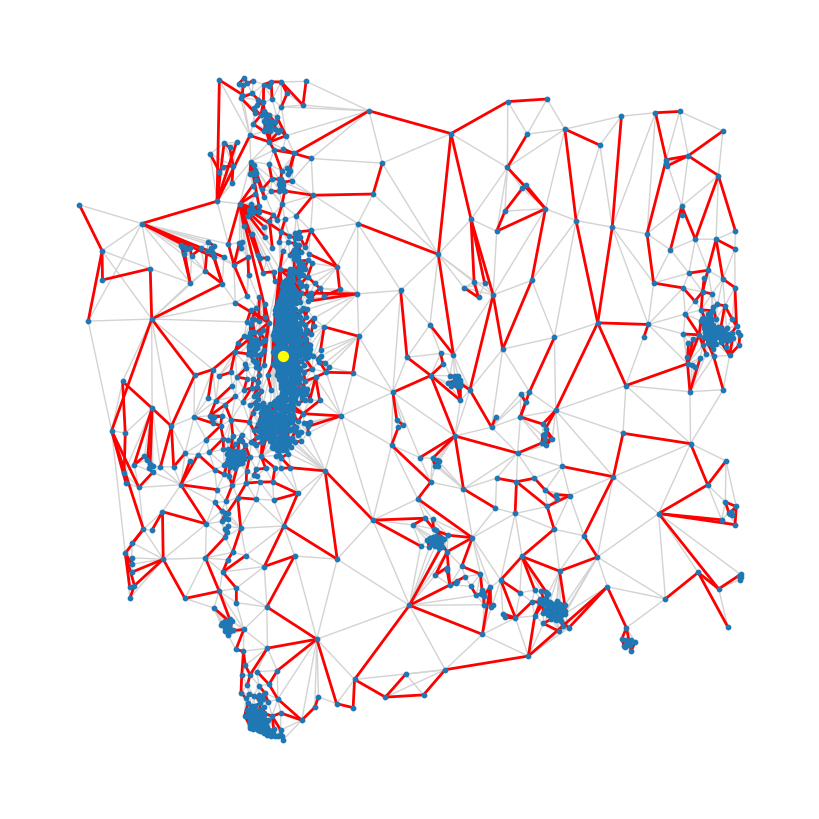

In [129]:
#plot of t's spannig tree 
node_locations = {v: (float(t.nodes()[v]["INTPTLON20"]) - 360 if float(t.nodes()[v]["INTPTLON20"]) > 0 else float(t.nodes()[v]["INTPTLON20"]),
        float(t.nodes()[v]["INTPTLAT20"]))for v in t.nodes()}
wilson = WilsonsAlgorithm(t)
spanning_tree, root = wilson.sample()
wilson.draw_tree(spanning_tree, root, node_locations)

In [133]:
def run_partition_simulations(graph, p, k):
    successful_splits = 0
    trials = 0

    while successful_splits < k:
        trials += 1
        partitioner = GraphPartitioner(graph, p)
        
        if partitioner.create_weighted_partitions_and_draw_spanning_tree():
            successful_splits += 1

    print(f"It took {trials} trials to achieve {k} successful splits for {p} partitions.")
    return trials


run_partition_simulations(t, p=2, k=144)  



It took 642062 trials to achieve 144 successful splits for 2 partitions.


642062

In [63]:
#IGNORREEEEEEEEEE
def run_partition_simulations(graph, k, num_trials=100000, total_runs=10):
    success_rates = []
    
    for run in range(total_runs):
        successful_splits = 0  
        for i in range(num_trials):
            partitioner = GraphPartitioner(graph, k)
            if partitioner.create_weighted_partitions_and_draw_spanning_tree(): 
                successful_splits += 1
        
        success_rate = (successful_splits / num_trials) * 100
        success_rates.append(success_rate)
    
    average_success_rate = sum(success_rates) / total_runs
    
    print("Success Rates for each run:", success_rates)
    print(f"Average Success Rate: {average_success_rate:.2f}%")
    
    return success_rates, average_success_rate

success_rates, average_success_rate = run_partition_simulations(cnty, 2)


Success Rates for each run: [0.011000000000000001, 0.013, 0.009000000000000001, 0.009000000000000001, 0.019, 0.013, 0.006, 0.012, 0.016, 0.013]
Average Success Rate: 0.01%
